In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [14]:
# load data
df = pd.read_csv('exoplanet_data.csv')

In [15]:
#Handle inconsistent entries
df['discoverymethod'] = df['discoverymethod'].str.strip().str.title()
df['disc_facility'] = df['disc_facility'].str.strip()

In [16]:
#handles misssing values
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill with 'Unknown'
cat_cols = df.select_dtypes(exclude=[np.number]).columns
df[cat_cols] = df[cat_cols].fillna('Unknown')

In [17]:
#Handles outliers
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower_bound, upper_bound)

# Apply to key numerical features
cols_to_cap = ['pl_orbper', 'pl_orbsmax', 'pl_rade', 'st_teff', 'st_mass', 'sy_dist']
for col in cols_to_cap:
    df[col] = cap_outliers(df[col])

In [18]:
# Habitability Score Index
# Radius Factor: 1.0 is perfect (Earth-sized)
rad_factor = np.exp(-abs(df['pl_rade'] - 1.0))

In [19]:
# Distance Factor: Calculate Habitable Zone based on Luminosity (L = R^2 * (T/5778)^4)
# Note: Using calculated luminosity if column is missing
st_lum_calc = (df['st_rad']**2) * ((df['st_teff']/5778)**4)
hz_center = np.sqrt(st_lum_calc)
dist_factor = np.exp(-abs(df['pl_orbsmax'] - hz_center) / (hz_center + 1e-5))

df['habitability_score'] = (rad_factor + dist_factor) / 2

In [20]:
# Stellar Compatibility Index
# Measures if the star is Sun-like (Mass ~ 1.0) and high metallicity
df['stellar_compatibility'] = np.exp(-abs(df['st_mass'] - 1.0)) * (1 + df['st_met'])

In [21]:

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_df = pd.DataFrame(
    encoder.fit_transform(df[['discoverymethod']]),
    columns=encoder.get_feature_names_out(['discoverymethod']),
    index=df.index
)
df = pd.concat([df, encoded_df], axis=1)

In [22]:
scaler = MinMaxScaler()
# Define all numerical columns including engineered ones
features_to_scale = list(num_cols) + ['habitability_score', 'stellar_compatibility']
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])


Validation plots saved as 'exoplanet_validation_plots.png'


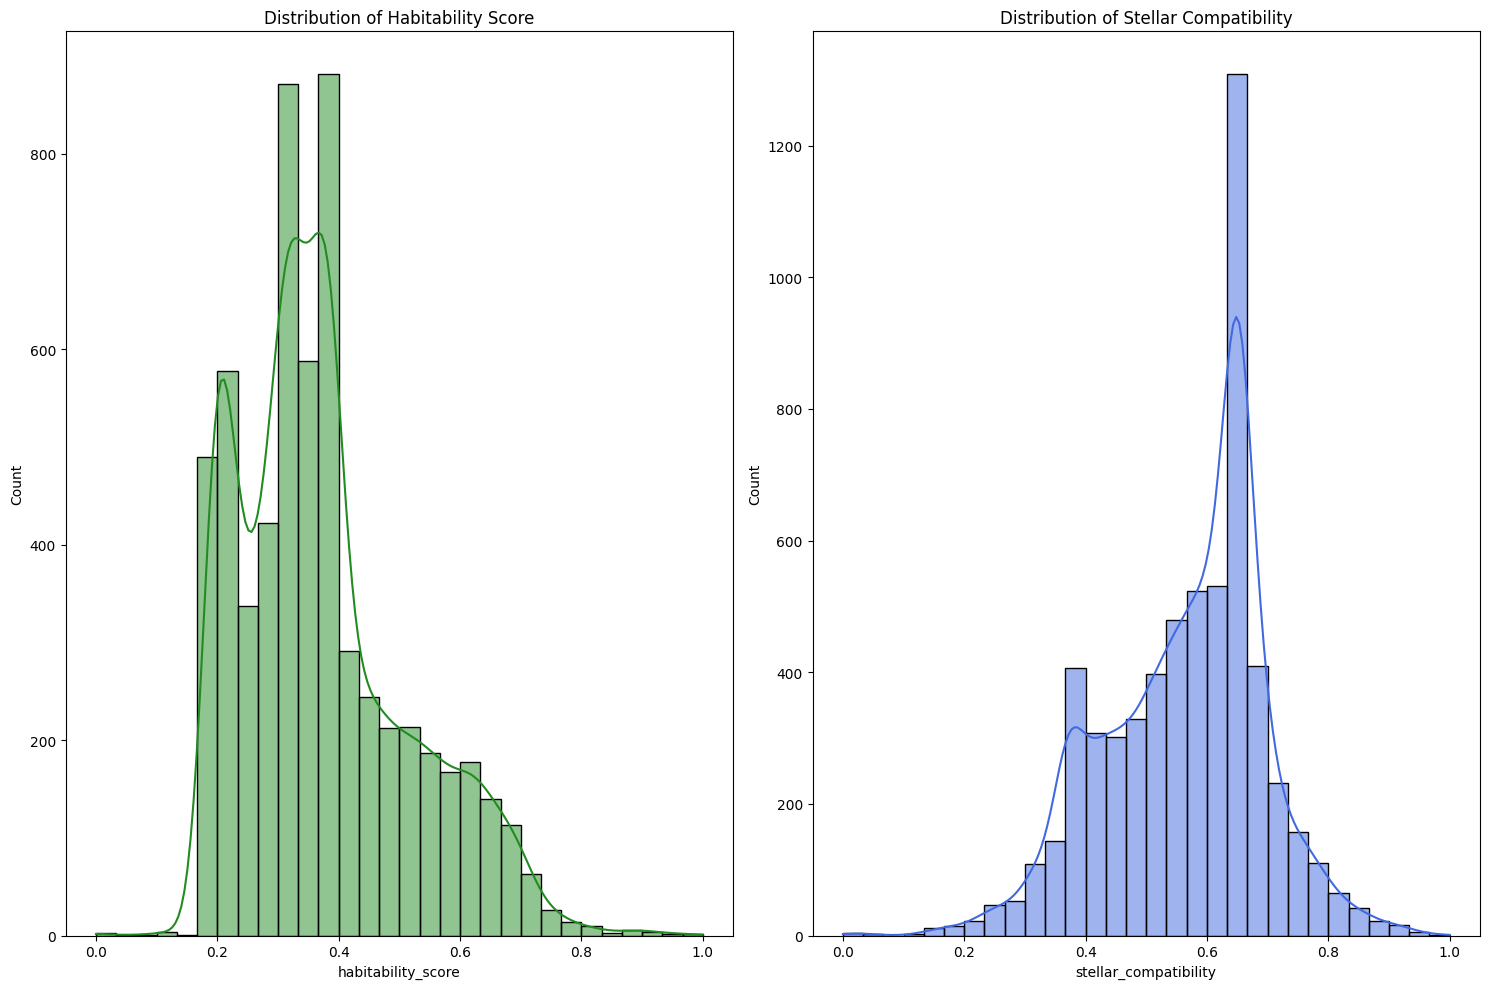

In [23]:
# Visualization of Engineered Indices
plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
sns.histplot(df['habitability_score'], bins=30, kde=True, color='forestgreen')
plt.title('Distribution of Habitability Score')

plt.subplot(1, 2, 2)
sns.histplot(df['stellar_compatibility'], bins=30, kde=True, color='royalblue')
plt.title('Distribution of Stellar Compatibility')

plt.tight_layout()
plt.savefig('exoplanet_validation_plots.png')
print("\nValidation plots saved as 'exoplanet_validation_plots.png'")

In [24]:
df.to_csv('final_processed_exoplanet_data.csv', index=False)
print("\nFinal processed data saved to 'final_processed_exoplanet_data.csv'")


Final processed data saved to 'final_processed_exoplanet_data.csv'


In [25]:
df.head()

,pl_name,hostname,sy_snum,sy_pnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,...,discoverymethod_Disk Kinematics,discoverymethod_Eclipse Timing Variations,discoverymethod_Imaging,discoverymethod_Microlensing,discoverymethod_Orbital Brightness Modulation,discoverymethod_Pulsar Timing,discoverymethod_Pulsation Timing Variations,discoverymethod_Radial Velocity,discoverymethod_Transit,discoverymethod_Transit Timing Variations
0,HR 8799 d,HR 8799,0.000000,0.428571,1.000000,1.000000,1.000000,0.170591,0.321055,0.340135,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,WASP-96 b,WASP-96,0.000000,0.000000,0.040660,0.130890,1.000000,0.170591,0.016324,0.016324,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,HD 114783 b,HD 114783,0.000000,0.142857,1.000000,1.000000,0.474115,0.027482,0.037412,0.037413,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,HAT-P-1 b,HAT-P-1,0.333333,0.000000,0.053342,0.163885,1.000000,0.187907,0.017855,0.017855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,HR 8799 b,HR 8799,0.000000,0.428571,1.000000,1.000000,1.000000,0.170591,0.214036,0.238094,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
